In [1]:
### Imports, some helper functions
import numpy as np
import xarray as xr
import glob
import os
import hashlib
import dask
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import colormaps
from matplotlib import cm
from dask.distributed import Client, LocalCluster
import seaborn as sns
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pprint import pp
from datetime import date

# let's test for now...
from xarray_cacher import *

In [2]:
### Data loading
# Corrected lat-lon grid will be handled separately 
model_grid = xr.open_mfdataset("/data/ycheng46/NNA/data/alaska_climate_region.nc")
static_lat2d = model_grid.lat.values
static_lon2d = model_grid.lon.values % 360

qflx_evap_paths = ["/data/shared_data/NNA/NNA.4km.hERA5.1989.003/qflx_evap_tot_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWh.2033.004/qflx_evap_tot_m/*.nc",
                 "/data/shared_data/NNA/NNA.4km.fPGWm.2033.005/qflx_evap_tot_m/*.nc" ]
qflx_evap_P, qflx_evap_H, qflx_evap_M = unpacker(qflx_evap_paths, "QFLX_EVAP_TOT")

In [3]:
### Data editing

## Constants
seconds_per_year = 365.25 * 86400
seconds_per_season = 90.25 * 86400

## Helpers for our cache functions    
def compute_annual_generic(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_annual_runoff(ds):
    return ds.groupby("time.year").mean(dim="time", skipna=True, keep_attrs=True)

def compute_geo_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(2034, 2064))

def compute_geo_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sel(year=slice(1990, 2020))

def compute_layer_average_future(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(2034, 2064))

def compute_layer_average_historic(ds):
    return ds.mean(dim=("lat", "lon"), skipna=True, keep_attrs=True).sum(dim="levsoi").sel(year=slice(1990, 2020))

## Evapotranspiration
total_qflx_evap_P = qflx_evap_P * seconds_per_year
total_qflx_evap_H = qflx_evap_H * seconds_per_year
total_qflx_evap_M = qflx_evap_M * seconds_per_year

annual_qflx_evap_P = cache_xarray(compute_annual_generic, total_qflx_evap_P, name_hint="total_qflx_evap_P")
annual_qflx_evap_H = cache_xarray(compute_annual_generic, total_qflx_evap_H, name_hint="total_qflx_evap_H")
annual_qflx_evap_M = cache_xarray(compute_annual_generic, total_qflx_evap_M, name_hint="total_qflx_evap_M")

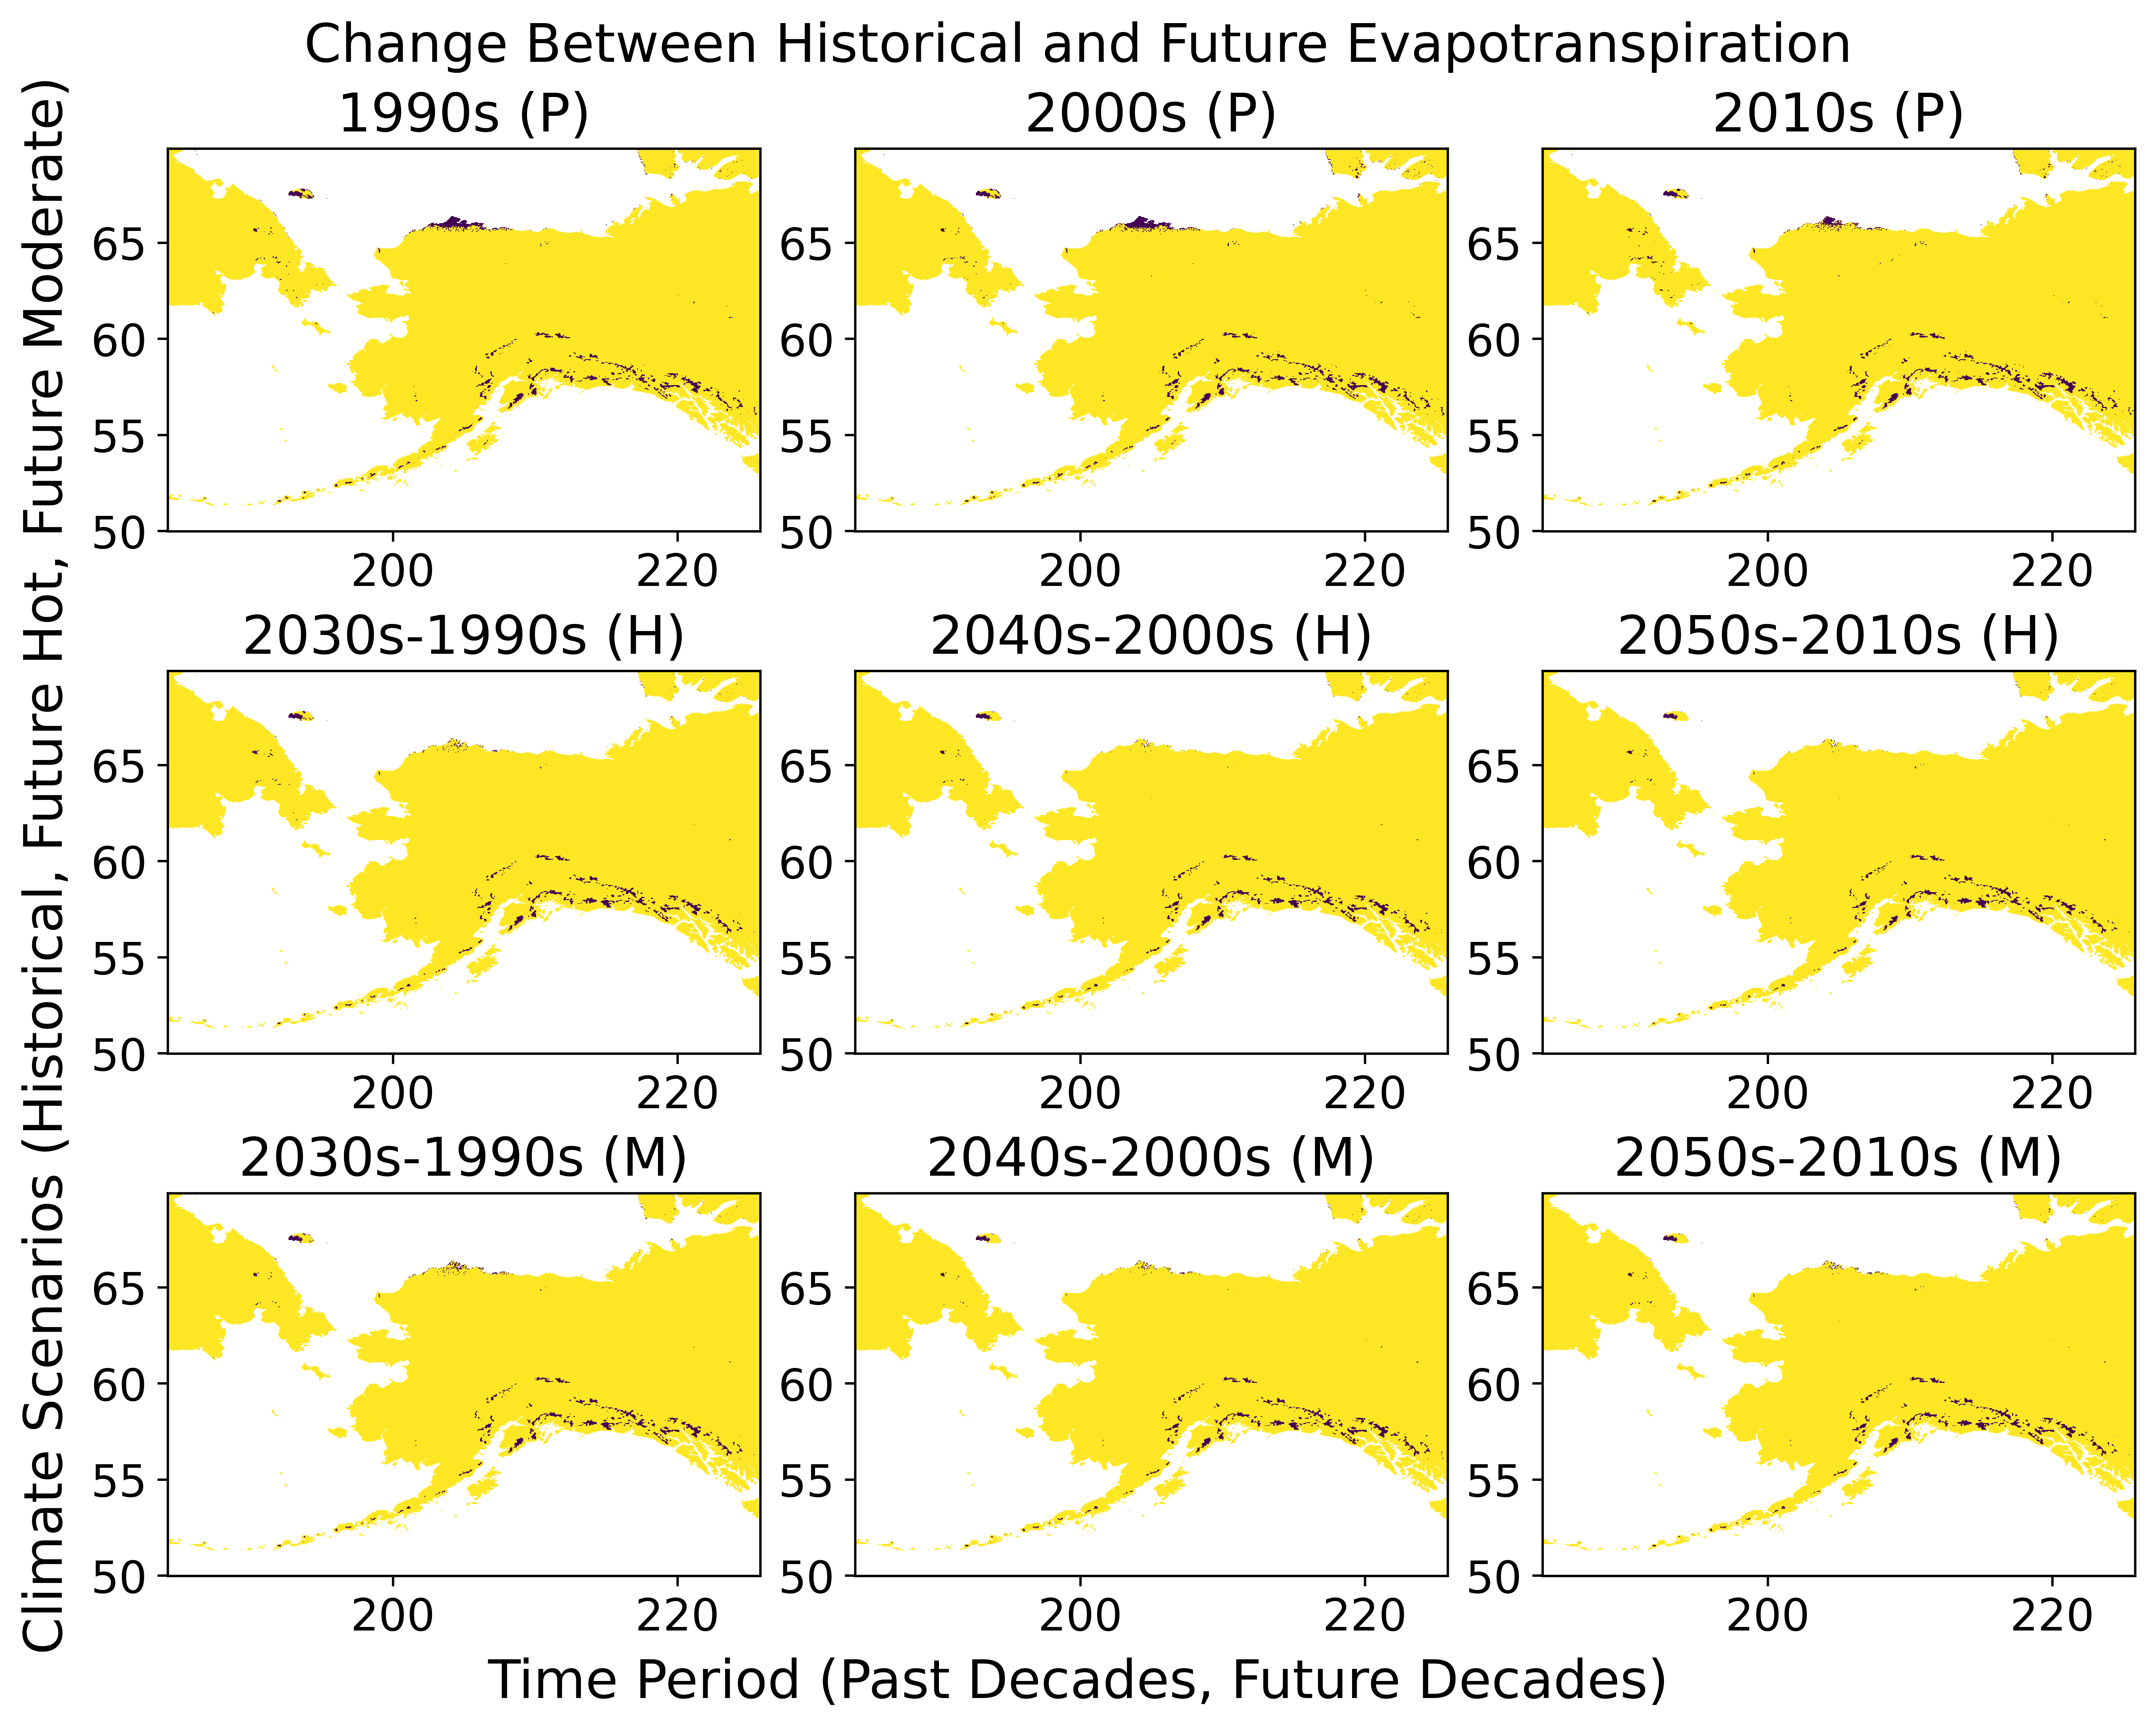

In [4]:
### Data loading: cached numpy results

# TODO: some are not evenly sized (the last one of the futures), not quite sure what to do about that
# TODO: this was the start of some evapotranspiration analysis. The plotting stuff here gives you some starting place,
# but you're mostly on your own in order to make this more usable. Good luck!

# 10-year slices (P)
# 1990-1991 to 1999-2000
# 2000-2001 to 2009-2010
# 2010-2011 to 2019-2020

qflx_evap_1990s_P = annual_qflx_evap_P.sel(year=slice("1990-1991", "1999-2000")).mean(dim="year")
qflx_evap_2000s_P = annual_qflx_evap_P.sel(year=slice("2000-2001", "2009-2010")).mean(dim="year")
qflx_evap_2010s_P = annual_qflx_evap_P.sel(year=slice("2010-2011", "2019-2020")).mean(dim="year")

qflx_evap_historical = [ qflx_evap_1990s_P, qflx_evap_2000s_P, qflx_evap_2010s_P ]
qflx_evap_historical_titles = [ "1990s (P)", "2000s (P)", "2010s (P)" ]

# used for making the diff maps
qflx_evap_historical_mean = xr.concat(qflx_evap_historical, dim='time').mean(dim='time')

# 10-year slices (H)
# 2034-2035 to 2044-2045
# 2045-2046 to 2054-2055
# 2055-2056 to 2063-2064 

qflx_evap_2030s_H = annual_qflx_evap_H.sel(year=slice("2034-2035", "2044-2045")).mean(dim="year")
qflx_evap_2040s_H = annual_qflx_evap_H.sel(year=slice("2045-2026", "2054-2055")).mean(dim="year")
qflx_evap_2050s_H = annual_qflx_evap_H.sel(year=slice("2055-2056", "2063-2064")).mean(dim="year")

qflx_evap_hots = [ qflx_evap_2030s_H, qflx_evap_2040s_H, qflx_evap_2050s_H ]
qflx_evap_hots_titles = [ "2030s-1990s (H)", "2040s-2000s (H)", "2050s-2010s (H)" ]

# 10-year slices (M)
# 2034-2035 to 2044-2045
# 2045-2046 to 2054-2055
# 2055-2056 to 2063-2064

qflx_evap_2030s_M = annual_qflx_evap_M.sel(year=slice("2034-2035", "2044-2045")).mean(dim="year")
qflx_evap_2040s_M = annual_qflx_evap_M.sel(year=slice("2045-2026", "2054-2055")).mean(dim="year")
qflx_evap_2050s_M = annual_qflx_evap_M.sel(year=slice("2055-2056", "2063-2064")).mean(dim="year")

qflx_evap_moderates = [qflx_evap_2030s_M, qflx_evap_2040s_M, qflx_evap_2050s_M ]
qflx_evap_moderates_titles = [ "2030s-1990s (M)", "2040s-2000s (M)", "2050s-2010s (M)" ]

all_vals = np.concatenate([
    qflx_evap_2030s_M.values, 
    qflx_evap_2040s_M.values, 
    qflx_evap_2050s_M.values,
    qflx_evap_2030s_H.values, 
    qflx_evap_2040s_H.values, 
    qflx_evap_2050s_H.values,
    qflx_evap_1990s_P.values, 
    qflx_evap_2000s_P.values, 
    qflx_evap_2010s_P.values
])

# remember: .plot(vmax=1)
plt.rc('font', size=15)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 8), dpi=600, constrained_layout=True)
fig.suptitle('Change Between Historical and Future Evapotranspiration')
fig.supxlabel('Time Period (Past Decades, Future Decades)')
fig.supylabel('Climate Scenarios (Historical, Future Hot, Future Moderate)')

for i, qflx_evap_da in enumerate(qflx_evap_historical):
    row, col = divmod(i, 3)
    data = qflx_evap_da.values
    lat = qflx_evap_da.lat.values
    lon = qflx_evap_da.lon.values

    mesh = axs[row, col].pcolormesh(lon, lat, data, cmap='viridis', vmin=0, vmax=0.1)
    axs[row, col].set_title(qflx_evap_historical_titles[i])
    axs[row, col].set_ylabel("")
    axs[row, col].set_xlabel("")

for i, qflx_evap_da in enumerate(qflx_evap_hots):
    row, col = divmod(i + 3, 3)
    diff = qflx_evap_da.values
    lat = qflx_evap_da.lat.values
    lon = qflx_evap_da.lon.values

    mesh = axs[row, col].pcolormesh(lon, lat, diff, cmap='viridis', vmin=0, vmax=0.1)
    axs[row, col].set_title(qflx_evap_hots_titles[i])
    axs[row, col].set_ylabel("")
    axs[row, col].set_xlabel("")

for i, qflx_evap_da in enumerate(qflx_evap_moderates):
    row, col = divmod(i + 6, 3)
    diff = qflx_evap_da.values
    lat = qflx_evap_da.lat.values
    lon = qflx_evap_da.lon.values

    mesh = axs[row, col].pcolormesh(lon, lat, diff, cmap='viridis', vmin=0, vmax=0.1)
    axs[row, col].set_title(qflx_evap_moderates_titles[i])
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')

norm = colors.Normalize(vmin=-0.2, vmax=0.2)
sm = cm.ScalarMappable(norm=norm, cmap='RdBu')
sm.set_array([])

norm_top = colors.Normalize(vmin=0, vmax=1)
sm_top = cm.ScalarMappable(norm=norm_top, cmap='viridis')
sm_top.set_array([])

#fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label="Max SWE / Total Snow + Rain (Delta) Ratio")
#fig.colorbar(sm_top, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label="Max SWE / Total Snow + Rain Ratio")
#fig.colorbar(label="Snow Runoff Ratio", extend="max")

## saving this work to disk
os.makedirs("qflx_evap_plots", exist_ok=True)
plt.savefig(f"qflx_evap_plots/plot-decades.png")
